# Population Receptive Field (pRF) estimates of the auditory cortex

This script demonstrates a simple pRF mapping workflow for a 1D frequency continuum.
We generate a grid of possible Gaussian tuning curves, load single trial beta estimates from our fMRI data,
then perform cross-validation to identify each voxel's best-fit tuning function.

## Prerequisites

Participants completed 6 runs, each containing 240 tones drawn from a frequency continuum spanning 200 Hz to 6000 Hz. We applied a single-trial GLM to these data, resulting in separate beta estimates for every one of these tone presentations.

<img src="./misc/tonotopy_design.svg" alt="Tonotopy Design" width="500"/>


**Single-Trial Beta estimates**: which represent the magnitude of the BOLD response elicited by each individual stimulus event. These estimates can be obtained from fMRI data using a single-trial GLM or packages like GLM-Single.

<img src="https://user-images.githubusercontent.com/35503086/151108958-24479034-c7f7-4734-b903-9046ba6a78ac.png" alt="GLM Single" width="700"/>


## 1) Setup: Define transformations & paths

In [1]:
% Define Log2 transformations for going back and forth between Hz and log (octave)-space
inv_transform = @(x) 2.^x;   % from log2 space to Hz
log_transform = @(x) log2(x);% from Hz to log2 space

% Add path to custom permutation functions
addpath(genpath('purmutation'));

## 2) Define the frequency continuum
Here, we create the set of all possible Gaussian tuning functions 
(the "`dictionary`" or "`grid`" for the pRF model). We do so by 
discretizing the **frequency axis** and a range of **tuning widths**.

In [2]:
% Frequency range (in Hz): from 200 Hz to 6000 Hz, 
steps        = 240;                                                          % number of continua steps (in this case matching stimuli)
ff_oct       = linspace(log_transform(200), log_transform(6000), steps);     % create the grid in steps
ff_hz        = inv_transform(ff_oct);                                        % actual frequencies (Hz)

% Subsample if desired (e.g., freqstep = 1 means we take every point)
freqstep     = 1; 
subsample    = 1:freqstep:length(ff_hz);

% Define Full-Width-Half-Max (FWHM) range and number of steps
tunsteps     = 10;                                                           % number of tuningwidth steps
fwhm         = linspace(25, 180, tunsteps);                                  % example: from narrower to wider
fwhm         = sort(fwhm, 'descend');                                        % descending order

% The bin spacing in log2 space between subsequent frequency bins:
mustep_all   = diff(log_transform(ff_hz(subsample)));
mustep       = mustep_all(1);                                                % if uniform

% Create a grid of pRF centers (mu) and widths (sigma) in this log domain
muarray_bins = log_transform(ff_hz);                                         % all frequency bins   
muarray      = log_transform(ff_hz(subsample));                              % possible center frequencies, in log2 space
sigmagrid    = log_transform(2)./(mustep(1).*fwhm/2).^2;                     % grid of tuning width, in sigma units
octgrid      = log2(inv_transform((fwhm-1)*mustep(1)));                      % same grid converted to octaves

% (Optional) show approximate range of widths:
disp('Approximate FWHM range in log2 domain:');
approx_sigma = mustep * fwhm;  
disp(['From ~', num2str(approx_sigma(end)), ' to ', num2str(approx_sigma(1)), ' in log2 scale.']);

Approximate FWHM range in log2 domain:
From ~0.51327 to 3.6956 in log2 scale.


## 3) Build the dictionary of all Gaussian pRF shapes
Here, we create the dictionary for al gaussian pRF shapes, 
where W is the prfMU x prfS matrix.

In [3]:
% Calculate needed sizes for variables
musteps    = numel(muarray);           % # of center-frequency steps
ssteps     = numel(sigmagrid);         % # of sigma steps
colormapMU = sort(linspace(-10, 10, musteps), 'descend');  % for coloring mu in BrainVoyager (-10, 10)
colormapS  = sort(linspace(-10, 10, ssteps), 'descend');   % for coloring sigma in BrainVoyager (-10, 10)
ns         = length(sigmagrid);        % just a shorthand

% Pre-allocate / initialize outputs
W      = [];    % The final dictionary matrix (i.e. the Grid)
prfMU  = [];    % Center-frequencies (mu) for each column in W
prfS   = [];    % Sigma values for each column in W
prfO   = [];    % Octave width
CM     = [];    % Color map entries for mu
CS     = [];    % Color map entries for sigma

% Squared distance between each frequency bin and each center (in log2 space)
D2     = (muarray_bins' - muarray).^2;

% Pre-allocate W: rows = # frequency bins, columns = # total (mu x sigma)
W      = zeros(length(muarray), musteps * ssteps);

% Loop over each sigma value, build all Gaussians at once
for it = 1:ns
    % For the current sigma, fill in the columns of W corresponding to all mus
    %   exp(- sigmagrid(it) * (bin - mu)^2 ) for each bin & each mu.
    colIdx = ((it - 1)*musteps + 1) : (it*musteps);
    W(:, colIdx) = exp(-sigmagrid(it) .* D2);
    
    % Popluate the variables
    prfS  = [prfS;  zeros(musteps,1) + sigmagrid(it)];
    prfMU = [prfMU; muarray'];  
    prfO  = [prfO;  zeros(musteps,1) + octgrid(it)];
    CM    = [CM;    colormapMU'];
    CS    = [CS;    zeros(musteps,1) + colormapS(it)];
end

#### (Optional): Visualizing the Gaussian pRF dictionary

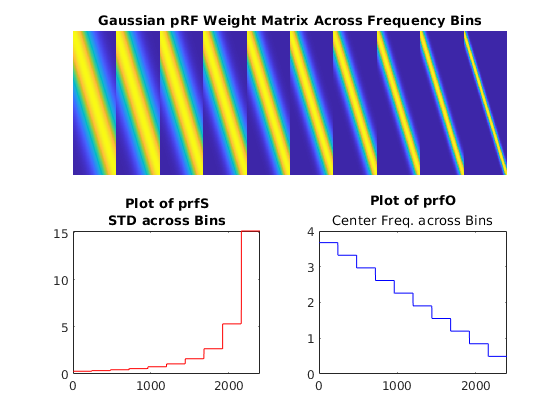

In [4]:
figure;

% First row: Full-width image
subplot(2,1,1); % Two rows, one column, first plot
imagesc(W);
title('Gaussian pRF Weight Matrix Across Frequency Bins');
axis off; 

% Second row: Two side-by-side plots
subplot(2,2,3); % Two rows, two columns, third plot
plot(prfS, 'r');
title({'Plot of prfS', 'STD across Bins'});

subplot(2,2,4); % Two rows, two columns, fourth plot
plot(prfO, 'b');
title({'Plot of prfO'}, {'Center Freq. across Bins'});

## 4) Load single-trial fMRI betas & visualize example voxels
We assume you have single-trial beta estimates (saved as `BetasSEPTrain`) and
a frequency map (`FMapTrain`) that indicates the amplitude or significance
of each voxel's response to the frequency continuum. 

Here we load both in.

In [5]:
% Load your data file (example name shown)
dataFile        = fullfile('Betas_RH_Auditory_denoise0_cv1.mat');
load(dataFile, 'BetasSEPTrain', 'FMapTrain', 'InfoVTCTrain');

% Optional: Filter voxels based on some threshold in the F-map
pth             = 0.0;                          % threshold in percentile (0 means keep all)
selvox          = FMapTrain > pth;              % e.g., keep everything for this demo

% Filter Betas to keep only selected voxels
BetasSEPTrain   = BetasSEPTrain(:, selvox);
fmap            = FMapTrain(selvox); 
[ntrials, nvox] = size(BetasSEPTrain);

#### (Optional): Visualizing the Single-Trial Beta estimation over the continuum - for 3 voxels

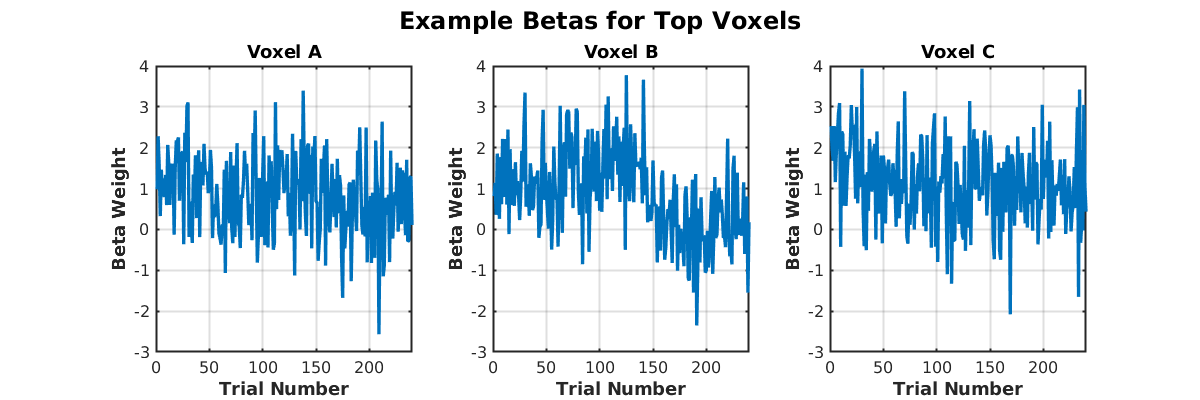

In [6]:
% As a quick example, let's pick top 1% of voxels in the map and visualize a few:
top_percentile  = prctile(fmap, 99);             % 99th percentile
top_voxels_idx  = find(fmap >= top_percentile);  % Indices within the filtered set
nToShow         = min(3, length(top_voxels_idx));

% Randomly select up to 3 voxels
selected_voxels = randsample(top_voxels_idx, nToShow);

% Extract and plot their betas
beta_values = BetasSEPTrain(:, selected_voxels);

figure('Color', [1,1,1], 'Position', [100, 100, 1200, 400]);
for i = 1:nToShow
    subplot(1, nToShow, i);
    plot(beta_values(:, i), 'LineWidth', 2.5);
    xlabel('Trial Number', 'FontSize', 14, 'FontWeight', 'bold');
    ylabel('Beta Weight', 'FontSize', 14, 'FontWeight', 'bold');
    title(['Voxel ' char('A' + i - 1)], 'FontSize', 16, 'FontWeight', 'bold');
    grid on;
    set(gca, 'FontSize', 12, 'LineWidth', 1.5);
end
sgtitle('Example Betas for Top Voxels', 'FontSize', 18, 'FontWeight', 'bold');
% Optimize layout
set(gcf, 'PaperPositionMode', 'auto');

## 5) Cross-validation & Fitting
We take two approaches:
1. Grid Search by max correlation
2. Permutation-based approach for significance testing

We'll store the best-fitting '`seed`' (column in `W`) for each voxel under both.

In [7]:
% K-fold cross-validation
kfold           = 6;
cv              = cvpartition(ntrials, 'kfold', kfold);

% Create or load a null-hypothesis structure for permutations
% (e.g., random reassignments).
nperm           = 1000;
H0              = get_penaltybasedonRanks(eye(size(W, 1)), [], [], nperm, W);

% Preallocate
bestSeed_grid_folds   = zeros(nvox, kfold + 1);    % best-fitting dictionary index from grid search
bestSeed_perm_folds   = zeros(nvox, kfold + 1);    % best-fitting dictionary index from permutation approach
cXteBest_grid_folds   = zeros(nvox, kfold + 1);    % store test correlation per fold
cXteBest_perm_folds   = zeros(nvox, kfold + 1);    % store test correlation per fold
trz                   = zeros(ntrials, kfold + 1); % store training sets
tez                   = zeros(ntrials, kfold + 1); % store testing sets

% For each fold in the CV, we find best seeds in the training set. 
for itcv = 1:(kfold + 1)

    % Do the train/test split
    if itcv <= kfold
        disp(['Cross Val Fold ' num2str(itcv)]);
        tr = cv.training(itcv);
        te = cv.test(itcv);
    else
        % Last pass: use all data as "training"
        disp(['Final pass: Whole data']);
        tr = true(ntrials,1);
        te = tr;
    end
    trz(:, itcv)    = tr;
    tez(:, itcv)    = te;
    
    % Extract training / test
    Xtr             = BetasSEPTrain(tr, :);         % Betas for training set
    Ftr             = W(tr, :);                     % Dictionary for training
    Xte             = BetasSEPTrain(te, :);         % Betas for test set
    Fte             = W(te, :);                     % Dictionary for test set

    % A) Grid Search: 
    %    For each voxel, find the column of Ftr that best correlates with Xtr.
    cXtrFtr                      = corr(Xtr, Ftr);                   % [nvox x #dictionaryCols]
    [bestTrainCorr, bestCol]     = max(cXtrFtr, [], 2);              % best-fitting column index
    bestSeed_grid_folds(:, itcv) = bestCol;                          % store results (overwrites each pass, as an example)
    %    Evaluate on test set
    bestDictTest                 = W(te, bestCol);                   % Each column corresponds to a voxel's best fit
    cXteBest_grid_folds(:, itcv) = diag(corr(Xte, bestDictTest));    % Test correlation of best match

    % B) Permutation-based approach:
    %    We fit Gaussian pRF based on ranks (or any cost function you define),
    %    then compare those ranks to a permutation-based null distribution (H0).
    %    The function returns the best-fitting 
    %    index (locRanks), the corresponding waveforms (Wprf), and p-values (pvalW).
    [locRanks, Wprf, pvalW]      = fitGaussianPrfbasedonRanks( ...
                                        eye(size(Ftr,1)), Xtr, prfS, prfMU, H0, Ftr, []);
    bestSeed_perm_folds(:, itcv) = locRanks;                       % store results

    % Evaluate on test set (analogous to cXteBest)
    bestDictTest                 = W(te, locRanks);  % Direct matrix indexing (no loop!)
    cXteBest_perm_folds(:, itcv) = diag(corr(Xte, bestDictTest)); % Store test correlation

end

% for now, lets take the full set for visualization
bestSeed_grid = bestSeed_grid_folds(:, end);
bestSeed_perm = bestSeed_perm_folds(:, end);

Cross Val Fold 1
Cross Val Fold 2
Cross Val Fold 3
Cross Val Fold 4
Cross Val Fold 5
Cross Val Fold 6
Final pass: Whole data


#### (Optional): Visualize the correlation between folds and in-train set

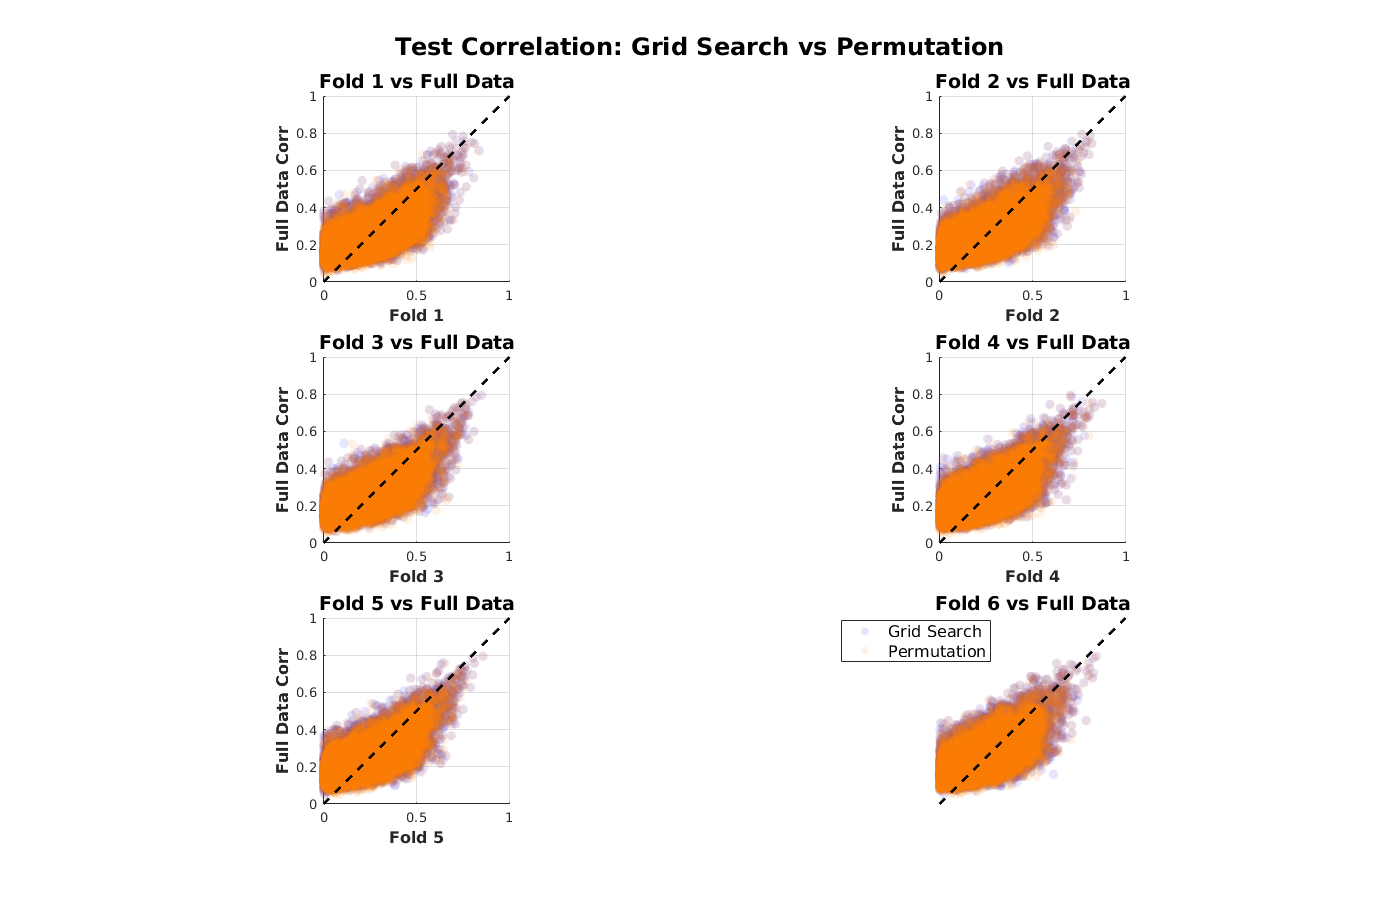

In [8]:
% Define grid layout
nRows = ceil(sqrt(kfold));  
nCols = ceil(kfold / nRows); 

% Create figure
figure('Color', 'w', 'Position', [100, 100, 1400, 900]);

for fold = 1:kfold
    subplot(nRows, nCols, fold);
    
    % Scatter plots for Grid Search (blue) and Permutation (orange)
    scatter(cXteBest_grid_folds(:, fold), cXteBest_grid_folds(:, end), 50, 'b', 'filled', 'MarkerFaceAlpha', 0.1); 
    hold on;
    scatter(cXteBest_perm_folds(:, fold), cXteBest_perm_folds(:, end), 50, [1, 0.5, 0], 'filled', 'MarkerFaceAlpha', 0.1);
    
    % Reference diagonal
    plot([0 1], [0 1], 'k--', 'LineWidth', 2);
    
    % Formatting
    xlabel(['Fold ' num2str(fold)], 'FontSize', 12, 'FontWeight', 'bold');
    ylabel('Full Data Corr', 'FontSize', 12, 'FontWeight', 'bold');
    title(['Fold ' num2str(fold) ' vs Full Data'], 'FontSize', 14);
    grid on; axis square; xlim([0 1]); ylim([0 1]);
end

% Global title
sgtitle('Test Correlation: Grid Search vs Permutation', 'FontSize', 18, 'FontWeight', 'bold');

% Legend in an empty subplot
subplot(nRows, nCols, kfold); axis off;
legend({'Grid Search', 'Permutation'}, 'Location', 'best', 'FontSize', 12);
% Optimize layout
set(gcf, 'PaperPositionMode', 'auto');

## 6) Saving data as maps
In this step, we convert the estimated pRF parameters into spatial maps, aligned with the original voxel indexing.

For visualization purposes, parameter values are scaled to a BrainVoyager understandable range of (**-10** to **10**). However, depending on your analysis goals, you might choose to store and visualize these parameters differently. For instance:

* **Raw parameter maps**: Save the original (unscaled) estimates directly as maps.
    * `prfMU(bestSeed_perm)`; `prfS(bestSeed_perm)`; `prfO(bestSeed_perm)`;
* **Fold-specific maps**: Retain separate parameter maps for each cross-validation fold to explore variability or reproducibility across runs.
    * `prfMU(bestSeed_grid_folds)`;
* **Fold-averaged maps**: Save the mean or median of parameter estimates across all folds to assess generalizability.
    * `mean(prfMU(bestSeed_grid_folds), 2)`; `median(prfMU(bestSeed_grid_folds), 2)`;

In [10]:
% Save maps for gridsearch
map = zeros(size(FMapTrain, 2), 2);
CM = round(CM);
map(selvox, 1) = CM(bestSeed_grid); % mean and 
map(selvox, 2) = CS(bestSeed_grid); % mean and 
saveICAMap('', '', map, ...
        {['prfMU'], ['TW']}, ...
        'prf_gridsearch', InfoVTCTrain);

% Save maps for permuations
map = zeros(size(FMapTrain, 2), 2);
map(selvox, 1) = CM(bestSeed_perm); % mean and 
map(selvox, 2) = CS(bestSeed_perm); % mean and 
saveICAMap('', '', map, ...
        {['prfMU'], ['TW']}, ...
        'prf_permutations', InfoVTCTrain);

saving: prf_gridsearch.vmp
saving: prf_permutations.vmp


## 7) (OPTIONAL:) Summarize Results Across Voxels
We compare the distribution of best-fitting *pRF center frequency* and 
*tuning widths* across **grid search** vs **permutation** approach.

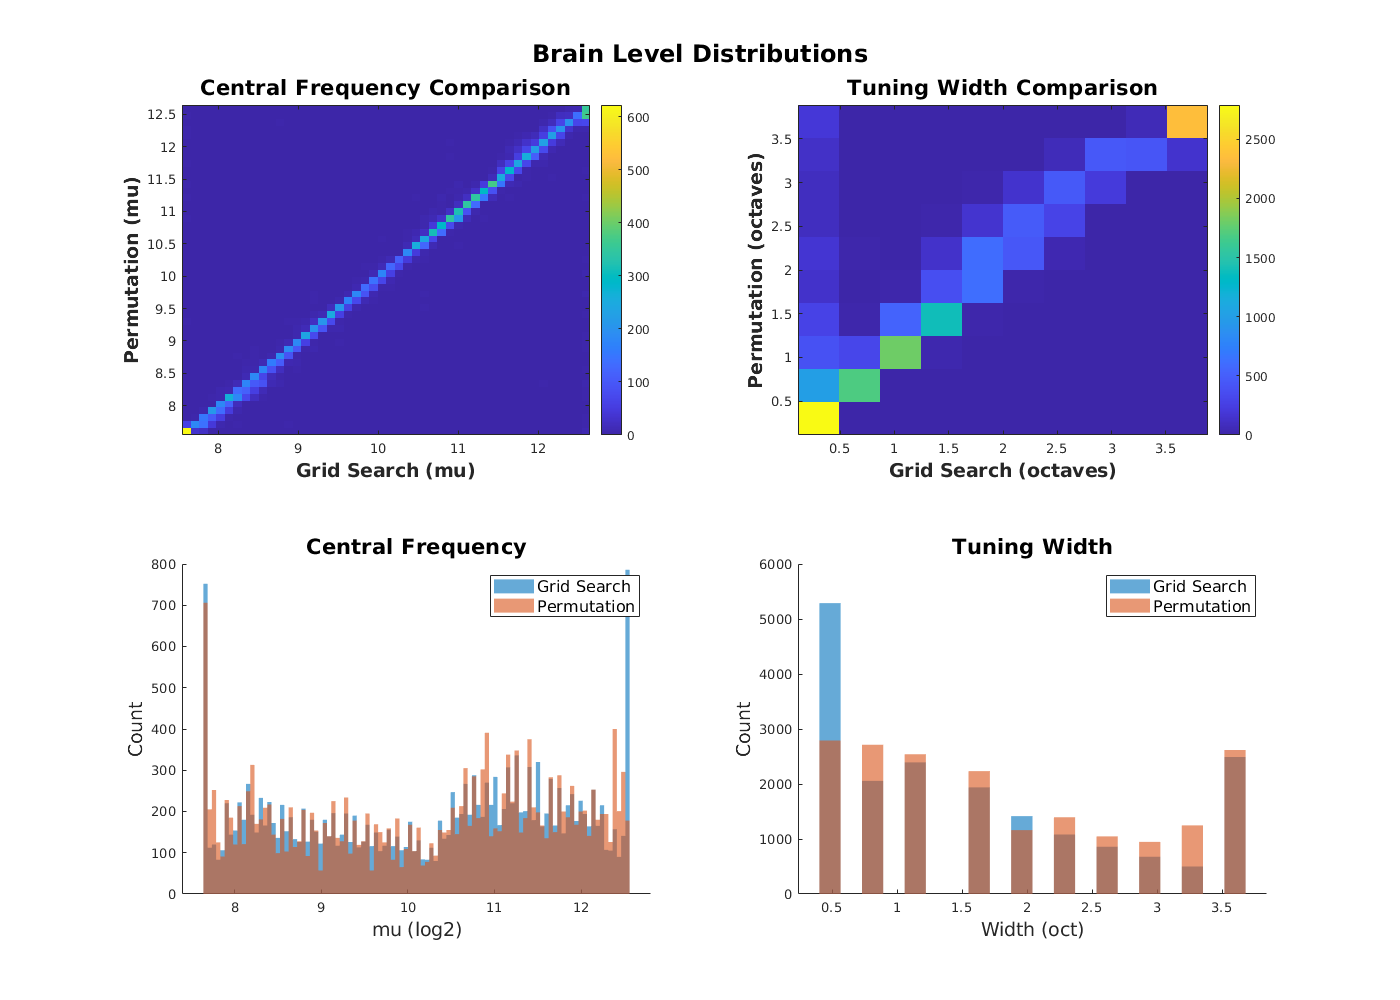

In [9]:
% Because prfMU, prfS, prfO correspond to columns, we can index with bestSeed_xxx:
selvox_idx = find(selvox);  % the absolute voxel indices in original data
grid_mu    = prfMU(bestSeed_grid); 
grid_o     = prfO(bestSeed_grid);

perm_mu    = prfMU(bestSeed_perm);
perm_o     = prfO(bestSeed_perm);

% Plot 2D histograms and 1D histograms comparing the two approaches
figure('Color', [1,1,1], 'Position', [100, 100, 1400, 1000]);

% (1) 2D histogram of central frequency
subplot(2,2,1);
[N,Xedges,Yedges] = histcounts2(grid_mu, perm_mu, [48 48]);
imagesc(Xedges, Yedges, N'); axis xy; colorbar;
xlabel('Grid Search (mu)', 'FontSize', 14, 'FontWeight', 'bold');
ylabel('Permutation (mu)', 'FontSize', 14, 'FontWeight', 'bold');
title('Central Frequency Comparison', 'FontSize', 16, 'FontWeight', 'bold');

% (2) 2D histogram of tuning width
subplot(2,2,2);
[N,Xedges,Yedges] = histcounts2(grid_o, perm_o, [10 10]);
imagesc(Xedges, Yedges, N'); axis xy; colorbar;
xlabel('Grid Search (octaves)', 'FontSize', 14, 'FontWeight', 'bold');
ylabel('Permutation (octaves)', 'FontSize', 14, 'FontWeight', 'bold');
title('Tuning Width Comparison', 'FontSize', 16, 'FontWeight', 'bold');

% (3) 1D histogram of central frequency
subplot(2,2,3); hold on;
h1 = histogram(grid_mu, 100, 'FaceAlpha', 0.6, 'EdgeColor', 'none'); 
h2 = histogram(perm_mu, 100, 'FaceAlpha', 0.6, 'EdgeColor', 'none');
title('Central Frequency', 'FontSize', 16, 'FontWeight', 'bold');
legend([h1, h2], {'Grid Search','Permutation'}, 'FontSize', 12);
xlabel('mu (log2)', 'FontSize', 14); ylabel('Count', 'FontSize', 14);

% (4) 1D histogram of tuning width
subplot(2,2,4); hold on;
h3 = histogram(grid_o, 20, 'FaceAlpha', 0.6, 'EdgeColor', 'none'); 
h4 = histogram(perm_o, 20, 'FaceAlpha', 0.6, 'EdgeColor', 'none');
title('Tuning Width', 'FontSize', 16, 'FontWeight', 'bold');
legend([h3, h4], {'Grid Search','Permutation'}, 'FontSize', 12);
xlabel('Width (oct)', 'FontSize', 14); ylabel('Count', 'FontSize', 14);
hold off;

sgtitle('Brain Level Distributions', 'FontSize', 18, 'FontWeight', 'bold');
% Optimize layout
set(gcf, 'PaperPositionMode', 'auto');

## 8) (OPTIONAL) Visualizing the pRF fit for an Example Voxel
Select an example voxel based on correlation strength *(e.g. >0.4)* and tuning width *(e.g. <1 octave)*
and visualize the voxel’s response compared to the best-fitting Gaussian from both approaches:
1. Grid Search
2. Permutation-based significance testing

Grid Search - prfMU: 10.6003
Grid Search - prfO: 0.84633
Permutation - prfMU: 10.5798
Permutation - prfO: 0.84633


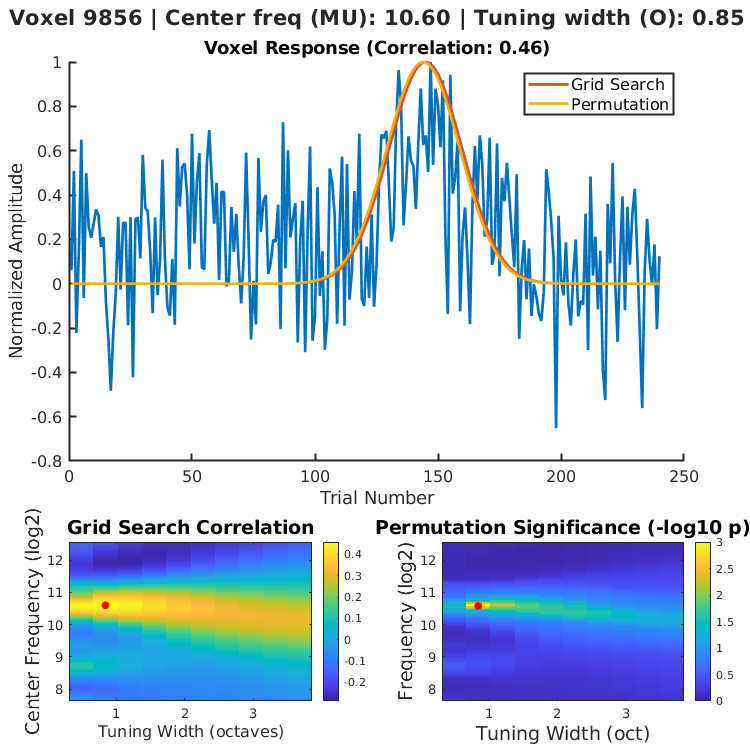

In [10]:
% Convert best-fitting grid indices into linear indices for extraction
indlin          = sub2ind(size(cXtrFtr), (1:nvox)', bestSeed_grid);
corrhat         = cXtrFtr(indlin);      % correlation with best-fitting Gaussian from grid search

% Choose voxel that meets selection criteria
%  (e.g. change bestSeed to > 3 for broader prfs) 
selected_voxels = find(corrhat > 0.4 & prfO(bestSeed_grid) < 1);
myvox           = selected_voxels(3);  % pick third voxel as an example

% Sort correlation values (for later use in plotting)
[~, ord]        = sort(cXtrFtr(myvox,:), 'ascend');

% Plotting the example voxel
fig             = figure('Color', [1,1,1], 'Position', [100, 100, 750, 750]);
tiledlayout(3,2,'TileSpacing','compact', 'Padding','compact');
sgtitle(sprintf('Voxel %d | Center freq (MU): %.2f | Tuning width (O): %.2f', ...
    myvox, prfMU(bestSeed_grid(myvox)), prfO(bestSeed_grid(myvox))), 'FontSize',16,'FontWeight','bold');

% Time series comparison plot (data vs. models)
ax1             = nexttile([2 2]); % larger plot
hold on;
plot(Xtr(:,myvox)./max(Xtr(:,myvox)), 'LineWidth', 2); % normalized voxel data
l1              = plot(Ftr(:, bestSeed_grid(myvox)), '-', 'LineWidth', 2);      % Grid search fit
l2              = plot(Ftr(:, bestSeed_perm(myvox)), '-', 'LineWidth', 2);      % Permutation fit
hold off;
legend([l1,l2], {'Grid Search', 'Permutation'}, 'FontSize',12);
title(sprintf('Voxel Response (Correlation: %.2f)', corrhat(myvox)), 'FontSize',14);
xlabel('Trial Number','FontSize',12);
ylabel('Normalized Amplitude','FontSize',12);
set(gca,'FontSize',12,'LineWidth',1.5);

% Grid Search correlation (cost function map)
ax2             = nexttile;
imagesc(octgrid, muarray, reshape(cXtrFtr(myvox,:), length(muarray), length(sigmagrid)));
colorbar; axis xy;
hold on;
plot(prfO(bestSeed_grid(myvox)), prfMU(bestSeed_grid(myvox)), '.r','MarkerSize',20);
hold off;
xlabel('Tuning Width (octaves)','FontSize',12);
ylabel('Center Frequency (log2)', 'FontSize',14);
title('Grid Search Correlation', 'FontSize',14,'FontWeight','bold');

% Permutation-based significance map (-log10 p-values)
ax3             = nexttile;
imagesc(octgrid, muarray, reshape(-log10(pvalW(myvox,:)), length(muarray), length(sigmagrid)));
colorbar; axis xy;
hold on;
plot(prfO(bestSeed_perm(myvox)), prfMU(bestSeed_perm(myvox)), '.r','MarkerSize',20);
hold off;
xlabel('Tuning Width (oct)', 'FontSize',14);
ylabel('Frequency (log2)', 'FontSize',14);
title('Permutation Significance (-log10 p)', 'FontSize',14,'FontWeight','bold');

% Print best-fit parameters to console for clarity
disp(['Grid Search - prfMU: ', num2str(prfMU(bestSeed_grid(myvox)))]);
disp(['Grid Search - prfO: ', num2str(prfO(bestSeed_grid(myvox)))]);
disp(['Permutation - prfMU: ', num2str(prfMU(bestSeed_perm(myvox)))]);
disp(['Permutation - prfO: ', num2str(prfO(bestSeed_perm(myvox)))]);

% Optimize layout
set(gcf,'PaperPositionMode','auto');

## 9) (OPTIONAL) Population Receptive Field (pRF) Mapping for Visual Stimuli

We explored pRF modeling in the auditory cortex. A similar approach can be applied to the visual cortex, but instead of frequency specificity, we examine preferences for visual eccentricity.
The core modeling approach is essentially the same between the two, with the key difference being dimensionality:
* **Auditory pRF mapping**: models voxel responses as a 1-dimensional Gaussian, tuned to a specific frequency range.
* **Visual pRF mapping**: extends this concept to a 2-dimensional Gaussian, capturing spatial tuning across the visual field (horizontal and vertical positions).

Thus using the intuition from auditory mapping directly transfers to the Gaussian Model used in visual pRF mapping - you're simply moving from a one-dimensional frequency continuum to a two-dimensional spatial domain.
The response of a voxel is modeled as a Gaussian sensitivity function over the visual field:

<img src="./misc/visual_prf_formula.png" alt="Visual pRF Formula" width="600"/>

where:
- `x0`, `y0` are the horizontal and vertical positions of the peak response.
- `σ` is the width of the receptive field, determining spatial spread.
- The stimulus response is computed as `G∗ ⋅ S`, This operation takes the dot product of the stimulus `S` with the Gaussian spatial profile, simulating the expected BOLD response in fMRI.

#### Model Pipeline

The following diagram illustrates the steps in visual pRF mapping:

<img src="https://i.imgur.com/ionIYpH.png" alt="Model pipeline" width="400"/>
